# Working with Images

In this notebook, we will go through the end-to-end pipeline of training conv nets, i.e. organising the data into directories, preprocessing, data augmentation, model building etc.  

In [21]:
# For downloading the dataset
# Go to Kaggle.com -> My Account -> Create new API Token -> Upload kaggle.json in Jupyter Home/CNN/
#!cp kaggle.json ~/.kaggle/kaggle.json
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle config set -n proxy -v http://10.140.0.96:3128
#!kaggle datasets download -d alxmamaev/flowers-recognition
#!unzip flowers-recognition.zip
#rm flowers-recognition.zip

In [24]:
# note that pip install skimage might throw an error, rather use this
!pip install scikit-image

In [27]:
!pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=8ef84313ce24d98b0cd046ec7ef02663ec06f9e52b1357effc60f76a4c52a9cd
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet


In [1]:
from google.colab import files
src = list(files.upload().values())[0]
open('resnet.py','wb').write(src)
import resnet

Saving resnet.py to resnet.py


In [2]:
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

##  Image Augmentation & Preprocessing

In the following section, we'll look at some common image preprocessing techniques.

### Understanding images and channels

As these images are RGB images they would constitute three channels - one for each of the color channels

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

#drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
cwd = os.getcwd()
cwd

'/content'

In [43]:
!ls

daisy  resnet.py  rose


In [6]:
#os.chdir('./gdrive/MyDrive/Colab Notebooks/flowers/')


In [5]:
# path to your dataset
DATASET_PATH = "./gdrive/MyDrive/Colab Notebooks/flowers/"
flowers_cls = ['daisy', 'rose']

We'll now use the `glob` module of python to <a href="https://en.wikipedia.org/wiki/Glob_(programming)">glob</a> through the directory where the data is stored, i.e. to walk through the directory, subdirectories and the files. It uses regular expressions to access files having names matching some pattern. In our case, we want to access all the files in the path `flowers/rose/` and `flowers/daisy/`, so we'll just use the regex `*` (used as a 'wildcard' to catch everything). 

An example of how the glob module works is given below - you first join the base directory path with the subdirectory (e.g. `flowers/rose/`) and then `glob` through it to access all the individual files (images here).

In [6]:
# globbing example
# help(glob)
flower_path = os.path.join(DATASET_PATH, flowers_cls[1], '*')
print(flower_path)

# glob through the directory (returns a list of all file paths)
flower_path = glob.glob(flower_path)
flower_path
#print(flower_path[1]) # access an individual file

./gdrive/MyDrive/Colab Notebooks/flowers/rose/*


['./gdrive/MyDrive/Colab Notebooks/flowers/rose/145862135_ab710de93c_n.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/319298955_0c72bd36bf.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/14176042519_5792b37555.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/5002458392_f465ed905e_n.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/9298314004_c1a8146521.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/2325232198_751645d0bb_n.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/3465443774_6b0c75a3b1_n.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/1757822526_fe30b9b3ca_m.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/7471890644_92a004ea92_n.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/3661675690_ed2d05fa5f_n.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/21413573151_e681c6a97a.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/7481118556_6c209b9b7d_n.jpg',
 './gdrive/MyDrive/Colab Notebooks/flowers/rose/15977362155_461030c196_m

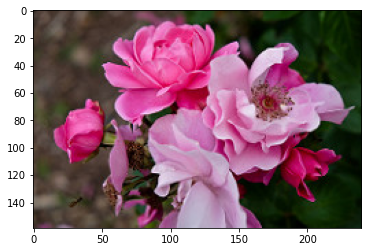

In [7]:
# run this block multiple times to look at some randomly chosen images of roses
rand_index = random.randint(0, len(flower_path))
image = io.imread(flower_path[rand_index])
plt.imshow(image)

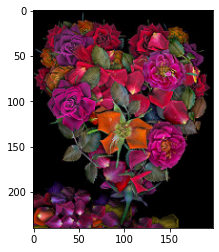

In [8]:

# plot a sample image
flower_path = os.path.join(DATASET_PATH, flowers_cls[1], '*')
flower_path = glob.glob(flower_path)

# access some element (a file) from the list
image = io.imread(flower_path[201])
plt.imshow(image)

In [9]:
print(image.shape)

(240, 198, 3)


Text(0.5, 0.98, 'Different Channels of Image')

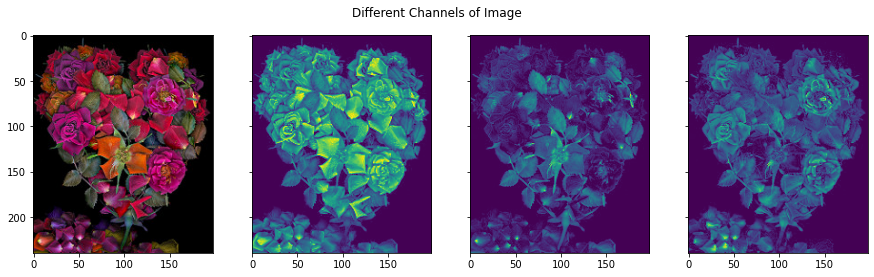

In [10]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')

## Morphological Transformations

### Thresholding

One of the simpler operations where we take all the pixels whose intensities are above a certain threshold, and convert them to ones; the pixels having value less than the threshold are converted to zero. This results in a *binary image*.

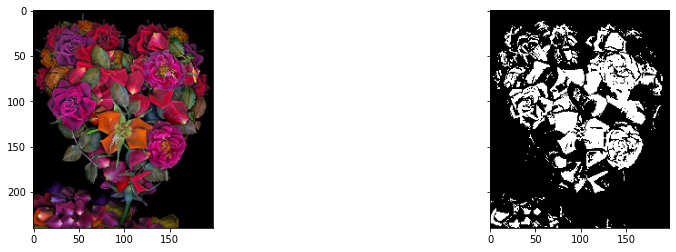

In [11]:
# bin_image will be a (240, 320) True/False array
bin_image = image[:, :, 0] > 125
plot_image([image, bin_image], cmap='gray')

### Erosion, Dilation, Opening & Closing

**Erosion** shrinks bright regions and enlarges dark regions. **Dilation** on the other hand is exact opposite side - it shrinks dark regions and enlarges the bright regions. 

**Opening** is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.

**Closing** is dilation followed by erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features.

All these can be done using the `skimage.morphology` module. The basic idea is to have a **circular disk** of a certain size (3 below) move around the image and apply these transformations using it.

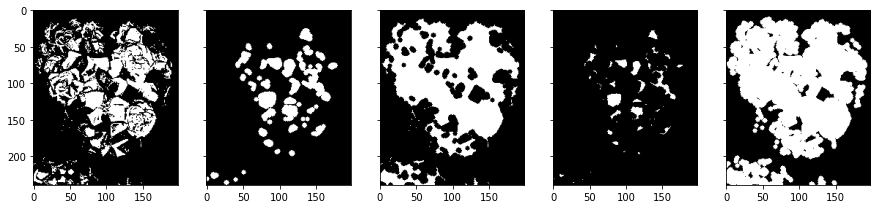

In [12]:
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import selem

# use a disk of radius 3
selem = selem.disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

## Normalisation 

Normalisation is the most crucial step in the pre-processing part. There are multiple ways to normalise images which we will be talking about.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


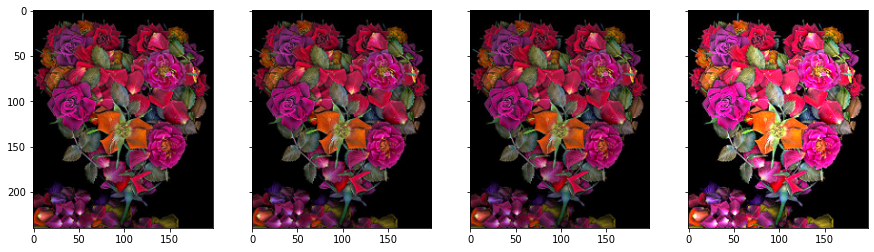

In [13]:
norm1_image = image/255
norm2_image = (image - np.min(image))/(np.max(image) - np.min(image))
norm3_image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))

plot_image([image, norm1_image, norm2_image, norm3_image], cmap='gray')

## Augmentations

There are multiple types of augmentations possible. The basic ones transform the original image using one of the following types of transformations:

1. Linear transformations
2. Affine transformations

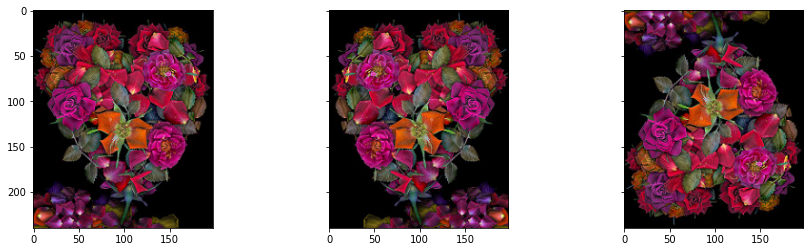

In [14]:
from skimage import transform

# flip left-right, up-down
image_flipr = np.fliplr(image)
image_flipud = np.flipud(image)

plot_image([image, image_flipr, image_flipud])

In [15]:
# help(transform)

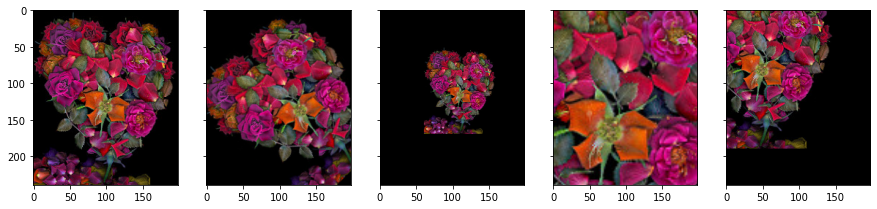

In [16]:
# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = transform.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  transform.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = transform.warp(image, rot_matrix)

# scaling 
scale_transforms = transform.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = transform.warp(image, scale_matrix)

scale_transforms = transform.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = transform.warp(image, scale_matrix)

# translation
transaltion_transforms = transform.AffineTransform(translation=(50, 50))
translated_image = transform.warp(image, transaltion_transforms)


plot_image([image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


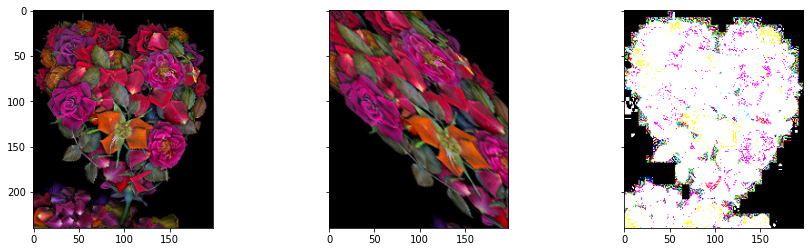

In [17]:
# shear transforms
shear_transforms = transform.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
shear_image = transform.warp(image, shear_matrix)

bright_jitter = image*0.999 + np.zeros_like(image)*0.001

plot_image([image, shear_image, bright_jitter])

<hr>

# Network Building

Let's now build the network. We'll import the resnet architecture from the module `resnet.py`.

In [18]:
import resnet

# specify image size and channels
img_channels = 3
img_rows = 100
img_cols = 100

# number of classes
nb_classes = 2

### Data Generator ###

Let's now set up the **data generator**. The code below sets up a custom data generator which is slightly different than <a href="https://keras.io/preprocessing/image/">the one that comes with the keras API</a>. The reason to use a custom generator is to be able to modify it according to the problem at hand (customizability). 


We won't be going through the entire code step-by-step in the lectures, though the code is explained below.

To start with, we have the training data stored in $n$ directories (if there are $n$ classes). For a given batch size, we want to generate batches of data points and feed them to the model.


The first `for` loop 'globs' through each of the classes (directories). For each class, it stores the path of each image in the list `paths`. In training mode, it subsets `paths` to contain the first 80% images; in validation mode it subsets the last 20%. In the special case of an ablation experiment, it simply subsets the first `ablation` images of each class.

We store the paths of all the images (of all classes) in a combined list `self.list_IDs`. The dictionary `self.labels` contains the labels (as key:value pairs of `path: class_number (0/1)`).

After the loop, we call the method `on_epoch_end()`, which creates an array `self.indexes` of length `self.list_IDs` and shuffles them (to shuffle all the data points at the end of each epoch).

The `_getitem_` method uses the (shuffled) array `self.indexes` to select a `batch_size` number of entries (paths) from the path list `self.list_IDs`. 

Finally, the method `__data_generation` returns the batch of images as the pair X, y where X is of shape `(batch_size, height, width, channels)` and y is of shape `(batch size, )`. Note that `__data_generation` also does some preprocessing - it normalises the images (divides by 255) and crops the center 100 x 100 portion of the image. Thus, each image has the shape `(100, 100, num_channels)`. If any dimension (height or width) of an image less than 100 pixels, that image is deleted.


In [19]:
import numpy as np
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'], 
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        """
        Initialise the data generator
        """
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        
        # glob through directory of each class 
        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
            
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

### Running Ablation Experiments 

Before training the net on the entire dataset, you should always try to first run some experiments to check whether the net is fitting on a small dataset or not. 

#### Checking that the network is 'working'

The first part of building a network is to get it to run on your dataset. Let's try fitting the net on only a few images and just one epoch. Note that since `ablation=100` is specified, 100 images of each class are used, so total number of batches is `np.floor(200/32)` = 6. 

Note that the `DataGenerator`  class 'inherits' from the `tf.keras.utils.Sequence` class, so it has all the functionalities of the base `tf.keras.utils.Sequence` class (such as the `model.fit_generator` method).

In [20]:
# using resnet 18
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='SGD',
              metrics=['accuracy'])

# create data generator objects in train and val mode
# specify ablation=number of data points to train on
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

# fit: this will fit the net on 'ablation' samples, only 1 epoch
model.fit(training_generator, epochs=1, validation_data=validation_generator)

6/6 [==============================] - 108s 18s/step - loss: 1.6214 - accuracy: 0.6283 - val_loss: 3.1015 - val_accuracy: 0.5000


### Overfitting on the Training Data

Let's now perform another important step which should be done before training the full-fledged model-  trying to **deliberately overfit the model** on a small dataset.

We'll use ablation=100 (i.e. training on 100 images of each class), so it is still a very small dataset, and we will use 20 epochs. In each epoch, 200/32=6 batches will be used.

In [24]:
# resnet 18
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

# generators
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

# fit
model.fit(training_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
6/6 [==============================] - 4s 400ms/step - loss: 1.6629 - accuracy: 0.5864 - val_loss: 9.3456 - val_accuracy: 0.5052
Epoch 2/20
6/6 [==============================] - 2s 290ms/step - loss: 1.5793 - accuracy: 0.6963 - val_loss: 7.3987 - val_accuracy: 0.4896
Epoch 3/20
6/6 [==============================] - 2s 299ms/step - loss: 1.5141 - accuracy: 0.7539 - val_loss: 5.8027 - val_accuracy: 0.5000
Epoch 4/20
6/6 [==============================] - 2s 294ms/step - loss: 1.4896 - accuracy: 0.7644 - val_loss: 4.6562 - val_accuracy: 0.5052
Epoch 5/20
6/6 [==============================] - 2s 288ms/step - loss: 1.4482 - accuracy: 0.7853 - val_loss: 3.8170 - val_accuracy: 0.5104
Epoch 6/20
6/6 [==============================] - 2s 288ms/step - loss: 1.4387 - accuracy: 0.8063 - val_loss: 3.1552 - val_accuracy: 0.5208
Epoch 7/20
6/6 [==============================] - 2s 304ms/step - loss: 1.4309 - accuracy: 0.7969 - val_loss: 2.5316 - val_accuracy: 0.5260
Epoch 8/20
6/6 [====

The results show that the training accuracy increases consistently with each epoch. The validation accuracy also increases and then plateaus out - this is a sign of 'good fit', i.e. we know that the model is at least able to learn from a small dataset, so we can hope that it will be able to learn from the entire set as well.

### Hyperparameter Tuning

First let's make a list the hyper-parameters we want to tune:

1. Learning Rate & Variation + Optimisers 
2. Augmentation Techniques

The basic idea is to track the validation loss with increasing epochs for various values of a hyperparameter. 

#### Keras Callbacks ####

Before you move ahead, let's discuss a bit about **callbacks**. Callbacks are basically actions that you want to perform at specific instances of training. For example, we want to perform the action of storing the loss at the end of every epoch (the instance here is the end of an epoch).


Formally, a callback is simply a function (if you want to perform a single action), or a list of functions (if you want to perform multiple actions), which are to be executed at specific events (end of an epoch, start of every batch, when the accuracy plateaus out, etc.). Keras provides some very useful callback functionalities through the class `tf.keras.callbacks.Callback`. 

Keras has many builtin callbacks (<a href="https://keras.io/callbacks/">listed here</a>). The generic way to **create a custom callback in keras** is:


In [22]:
# generic way to create custom callback
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In the code below, we have created a custom callback to append the loss to a list at the end of every epoch. Note that `logs` is an attribute (a dictionary) of `tf.keras.callbacks.Callback`, and we are using it to get the value of the key 'loss'. Some other keys of this dict are `acc`, `val_loss` etc.

To tell the model that we want to use a callback, we create an object of `LossHistory` called `history` and pass it to `model.fit_generator` using `callbacks=[history]`. In this case, we only have one callback `history`, though you can pass multiple callback objects through this list (an example of multiple callbacks is in the section below - see the code block of `DecayLR()`).

We highly recommend you to <a href="https://keras.io/callbacks/">read the documentation of keras callbacks here</a>. For a gentler introduction to callbacks, you can read this <a href="https://machinelearningmastery.com/check-point-deep-learning-models-keras/"> nice blog post by Jason Brownlee.</a>



In [ ]:
# help(tf.keras.callbacks.Callback)

In [23]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

# range of learning rates to tune
hyper_parameters_for_lr = [0.1, 0.01, 0.001]

# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    sgd = optimizers.SGD(lr=lr, clipnorm=1.)
    
    # model and generators
    model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
    model.compile(loss='categorical_crossentropy',optimizer= sgd,
                  metrics=['accuracy'])
    training_generator = DataGenerator('train', ablation=100)
    validation_generator = DataGenerator('val', ablation=100)
    model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[history])
    
    # plot loss history
    plot_data[lr] = history.losses



========================================   Checking for LR=0.1  ========================================


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/3
6/6 [==============================] - 6s 434ms/step - loss: 1.5476 - accuracy: 0.7016 - val_loss: 9.9329 - val_accuracy: 0.5052
Epoch 2/3
6/6 [==============================] - 2s 288ms/step - loss: 1.4216 - accuracy: 0.8168 - val_loss: 6.5120 - val_accuracy: 0.5000
Epoch 3/3
6/6 [==============================] - 2s 298ms/step - loss: 1.3918 - accuracy: 0.7749 - val_loss: 3.9266 - val_accuracy: 0.5625


========================================   Checking for LR=0.01  ========================================
Epoch 1/3
6/6 [==============================] - 6s 404ms/step - loss: 1.6433 - accuracy: 0.5759 - val_loss: 2.2981 - val_accuracy: 0.5000
Epoch 2/3
6/6 [==============================] - 2s 282ms/step - loss: 1.5193 - accuracy: 0.7120 - val_loss: 1.8556 - val_accuracy: 0.5469
Epoch 3/3
6/6 [==============================] - 2s 292ms/step - loss: 1.4912 - accuracy: 0.7330 - val_loss: 1.7846 - val_accuracy: 0.5573


========================================   Checking for 

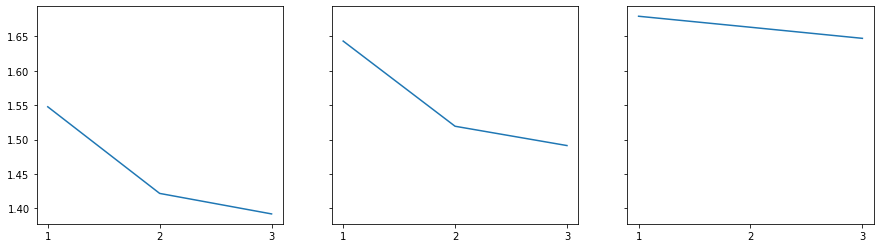

In [25]:
# plot loss history for each value of hyperparameter
f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.01]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

The results above show that a learning rate of 0.1 is the best, though using such a high learning rate for the entire training is usually not a good idea. Thus, we should use **learning rate decay** - starting from a high learning rate and decaying it with every epoch.

We use another **custom callback** (`DecayLR`) to decay the learning rate at the end of every epoch. The decay rate is specified as 0.5 ^ epoch. Also, note that this time we are telling the model to **use two callbacks** (passed as a list `callbacks=[history, decay]` to `model.fit_generator`).


Although we have used out own custom decay implementation here, you can use the ones built into <a href="https://keras.io/optimizers/">keras optimisers</a> (using the `decay` argument).

In [26]:
# learning rate decay
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.001, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    # set lr on_train_begin
    def on_train_begin(self, logs={}):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

    # change learning rate at the end of epoch
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(tf.keras.backend.get_value(self.model.optimizer.lr))
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)

# to store loss history
history = LossHistory()
plot_data = {}

# start with lr=0.1
decay = DecayLR(base_lr=0.1)

# model
sgd = optimizers.SGD()
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[history, decay])

plot_data[lr] = decay.lr_history

Epoch 1/3
6/6 [==============================] - 4s 396ms/step - loss: 2.2765 - accuracy: 0.5288 - val_loss: 2.0037 - val_accuracy: 0.7552
Epoch 2/3
6/6 [==============================] - 2s 304ms/step - loss: 1.4482 - accuracy: 0.7225 - val_loss: 9.6213 - val_accuracy: 0.5052
Epoch 3/3
6/6 [==============================] - 2s 285ms/step - loss: 1.3473 - accuracy: 0.8429 - val_loss: 7.2818 - val_accuracy: 0.5052


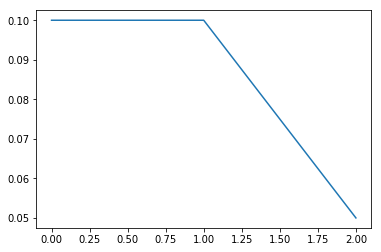

In [ ]:
plt.plot(np.arange(len(decay.lr_history)), decay.lr_history)

## Augmentation Techniques

Let's now write some code to implement data augmentation. Augmentation is usually done with data generators, i.e. the augmented data is generated batch-wise, on the fly. 

You can either use the built-in keras `ImageDataGenerator` or write your own data generator (for some custom features etc if you want). The two cells below show how to implement these respectively. 

In [ ]:
# keras data generator
# help(ImageDataGenerator)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

If you want to implement your own customized data generator (with augmentation), you can add the augmentation step easily to the `DataGenerator` class created above. The only change is that we stack the augmented images to the X, y arrays (as done in the last section of the code below).

In [ ]:
import numpy as np
import tensorflow as tf

# data generator with augmentation
class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'], 
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        # data augmentation
        if self.mode == 'train':
            aug_x = np.stack([datagen.random_transform(img) for img in X])
            X = np.concatenate([X, aug_x])
            y = np.concatenate([y, y])
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
        

### Metrics to optimise

AUC is often a better metric than accuracy. So instead of optimising for accuracy, let's monitor AUC and choose the best model based on AUC on validaton data. We'll use the callbacks `on_train_begin` and `on_epoch_end` to initialise  (at the start of each epoch) and store the AUC (at the end of epoch).

In [ ]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc


## Final Run

Let's now train the final model. Note that we will keep saving the best model's weights at `models/best_models.hdf5`, so you will need to create a directory `models`. Note that model weights are usually saved in hdf5 files.

**Saving the best model** is done using the callback functionality that comes with `ModelCheckpoint`. We basically specify the `filepath` where the model weights are to be saved, ` monitor='val_auc'` specifies that you are choosing the best model based on validation accuracy, `save_best_only=True` saves only the best weights, and `mode='max'` specifies that the validation accuracy is to be maximised.

In [ ]:
# model
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=32)
validation_generator = AugmentedDataGenerator('val', ablation=32)

# checkpoint 
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()

# fit
model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[auc_logger, history, decay, checkpoint])

Epoch 1/3
2/2 [==============================] - ETA: 0s - loss: 2.1315 - accuracy: 0.4375
Val AUC for epoch0: 0.51025390625

Epoch 00001: val_auc improved from -inf to 0.51025, saving model to models/best_model.hdf5
2/2 [==============================] - 2s 1s/step - loss: 2.1315 - accuracy: 0.4375 - val_loss: 26.2089 - val_accuracy: 0.5000 - val_auc: 0.5103
Epoch 2/3
2/2 [==============================] - ETA: 0s - loss: 2.0446 - accuracy: 0.6875
Val AUC for epoch1: 0.7900390625

Epoch 00002: val_auc improved from 0.51025 to 0.79004, saving model to models/best_model.hdf5
2/2 [==============================] - 1s 618ms/step - loss: 2.0446 - accuracy: 0.6875 - val_loss: 7.1659 - val_accuracy: 0.5000 - val_auc: 0.7900
Epoch 3/3
2/2 [==============================] - ETA: 0s - loss: 1.3234 - accuracy: 0.8594
Val AUC for epoch2: 0.817626953125

Epoch 00003: val_auc improved from 0.79004 to 0.81763, saving model to models/best_model.hdf5
2/2 [==============================] - 1s 612ms/ste

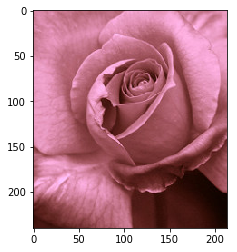

In [ ]:
plt.imshow(image)

In [ ]:
h, w, _ = image.shape
img = image[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]

model.predict(img[np.newaxis,: ])

array([[0., 1.]], dtype=float32)